In [ ]:
# 라이브러리 불러오기

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# 1. 데이터 불러오기
# 절대경로
path = "C:\study\_data\ddarung\\"
# 상대경로
# path = "_data\ddarung"

# index_col = 0 은 0번째 있는 id 를 index로 구분해줌 
train_csv = pd.read_csv(path+ "train.csv",index_col=0)
test_csv = pd.read_csv(path+"test.csv",index_col=0)
submission = pd.read_csv(path + "submission.csv",index_col=0)

In [ ]:
# 칼럼명 출력
print(train_csv.columns)

Index(['hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype='object')


In [ ]:

# 결측치 이상치를 확인해보기위한 카운트 조회
print(train_csv.info())

# 데이터셋을 결측치가 없는 데이터셋으로 초기화 
# 결측치 열 제거 
# 1. 결측치 처리 1. 제거 
train_csv = train_csv.dropna(axis=0)

# 결측치 가 있는 열 확인
train_csv.isnull().any()

# print(train_csv.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 3 to 2179
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hour                    1459 non-null   int64  
 1   hour_bef_temperature    1457 non-null   float64
 2   hour_bef_precipitation  1457 non-null   float64
 3   hour_bef_windspeed      1450 non-null   float64
 4   hour_bef_humidity       1457 non-null   float64
 5   hour_bef_visibility     1457 non-null   float64
 6   hour_bef_ozone          1383 non-null   float64
 7   hour_bef_pm10           1369 non-null   float64
 8   hour_bef_pm2.5          1342 non-null   float64
 9   count                   1459 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 125.4 KB
None


hour                      False
hour_bef_temperature      False
hour_bef_precipitation    False
hour_bef_windspeed        False
hour_bef_humidity         False
hour_bef_visibility       False
hour_bef_ozone            False
hour_bef_pm10             False
hour_bef_pm2.5            False
count                     False
dtype: bool

In [ ]:
# 데이터셋의 다양한 값들을 볼수는 describe
print(train_csv.describe())

              hour  hour_bef_temperature  hour_bef_precipitation  \
count  1328.000000           1328.000000             1328.000000   
mean     11.905120             16.866039                0.030120   
std       6.746907              5.196544                0.170983   
min       0.000000              3.100000                0.000000   
25%       6.000000             13.000000                0.000000   
50%      12.000000             16.800000                0.000000   
75%      18.000000             20.200000                0.000000   
max      23.000000             30.000000                1.000000   

       hour_bef_windspeed  hour_bef_humidity  hour_bef_visibility  \
count         1328.000000        1328.000000          1328.000000   
mean             2.489834          51.740964          1413.655120   
std              1.382797          20.167066           577.258705   
min              0.000000           7.000000            78.000000   
25%              1.400000          36.0000

In [ ]:
# 데이터 정리하기 x 
x = train_csv.drop(["count"],axis=1)

#  x는 이제 count 칼럼이 사라졌습니다!
print(x.head())
print(x.shape)

    hour  hour_bef_temperature  hour_bef_precipitation  hour_bef_windspeed  \
id                                                                           
3     20                  16.3                     1.0                 1.5   
6     13                  20.1                     0.0                 1.4   
7      6                  13.9                     0.0                 0.7   
8     23                   8.1                     0.0                 2.7   
9     18                  29.5                     0.0                 4.8   

    hour_bef_humidity  hour_bef_visibility  hour_bef_ozone  hour_bef_pm10  \
id                                                                          
3                89.0                576.0           0.027           76.0   
6                48.0                916.0           0.042           73.0   
7                79.0               1382.0           0.033           32.0   
8                54.0                946.0           0.040          

In [ ]:
# 데이터 정리하기 y
# count 칼럼만 가지고옵니다 이떄 train_csv 은 변형하지 않는게 포인트
y = train_csv["count"]
print(y.head())

print(y.shape)

id
3     49.0
6    159.0
7     26.0
8     57.0
9    431.0
Name: count, dtype: float64
(1328,)


In [ ]:
# 데이터를 분할하기
x_train, x_test, y_train,y_test = train_test_split(x,y,
                                                   train_size=0.7,
                                                   shuffle = True,
                                                   random_state=21
                                                   )

print(len(x_train))
print(len(x_test))

929
399


In [ ]:
# 2. 모델구성

model = Sequential([
    Dense(10,input_dim = 9),
    Dense(20, activation="relu"),
    Dense(20, activation="relu"),
    Dense(20, activation="relu"),
    Dense(20, activation="relu"),
    Dense(20, activation="relu"),
    Dense(20, activation="relu"),
    Dense(20, activation="relu"),
    Dense(40, activation="relu"),
    Dense(80, activation="relu"),
    Dense(80, activation="relu"),
    Dense(80, activation="relu"),
    Dense(160,activation="relu"),
    Dense(80, activation="relu"),
    Dense(80, activation="relu"),
    Dense(80, activation="relu"),
    Dense(40, activation="relu"),
    Dense(20, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                100       
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420       
                                                                 
 dense_6 (Dense)             (None, 20)                4

In [ ]:
# 3.컴파일 + 훈련
# gpu 걸린시간 :  12.08470892906189
# cpu 걸린시간 :  16.177061557769775
import time
from tensorflow.keras.callbacks import EarlyStopping
# 모니터 : val_loss 를 관찰
# mode : 값이 커질때 멈춤 , 값이 작아져야함
# patience : 개선이 안된다고 바로 종료시키지 않고 에폭을 기다림
# 
earlyStopping = EarlyStopping(monitor="val_loss",
                              mode="min",patience =10,
                              restore_best_weights=True,
                              verbose=1
                              )

model.compile(loss="mse",optimizer="adam")
start = time.time()
hist = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.25,
                 callbacks = [earlyStopping])

end = time.time()

print("걸린시간 : ",end-start)

Epoch 1/100
22/22 [==============================] - 1s 10ms/step - loss: 17448.7949 - val_loss: 6857.4248
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 8473.8438 - val_loss: 6648.0010
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 6666.5566 - val_loss: 7451.1616
Epoch 4/100
22/22 [==============================] - 0s 2ms/step - loss: 6987.2227 - val_loss: 6376.6284
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: 6580.8442 - val_loss: 7038.5063
Epoch 6/100
22/22 [==============================] - 0s 2ms/step - loss: 6682.2944 - val_loss: 6343.0005
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 6622.0308 - val_loss: 6314.2358
Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: 6494.0156 - val_loss: 6385.2319
Epoch 9/100
22/22 [==============================] - 0s 2ms/step - loss: 6648.2441 - val_loss: 6133.3848
Epoch 10/100
22/22 [==============================] -

In [ ]:
# 4. 성능평가

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

loss = model.evaluate(x_test,y_test)
print("loss : ",loss)

y_predict =model.predict(x_test)
# print("=================")
# print(y_test)
# print(y_predict)
# print("=================")

print("RMSE : ",RMSE(y_test,y_predict))
print("R2 : ",r2_score(y_test,y_predict))

13/13 [==============================] - 0s 791us/step - loss: 3561.6821
loss :  3561.68212890625
RMSE :  59.67983055332217
R2 :  0.45611234216944607


In [ ]:
# 15. 저장
# 제출용 but NaN 이 포함되어있다 ...
import pandas as pd
# 15-1.제출용를 predcit 로 뽑아냄
y_submit = model.predict(test_csv)
# 15-2.제촐용을 데이터프레임형으로 변환
y_submit = pd.DataFrame(y_submit)
# 15-2 제출용의 카운트 칼럼에 y_submit 삽입
submission["count"] = y_submit
# 15-3 경로와 파일명 지정
submission.to_csv(path + "submission_0101502151.csv")

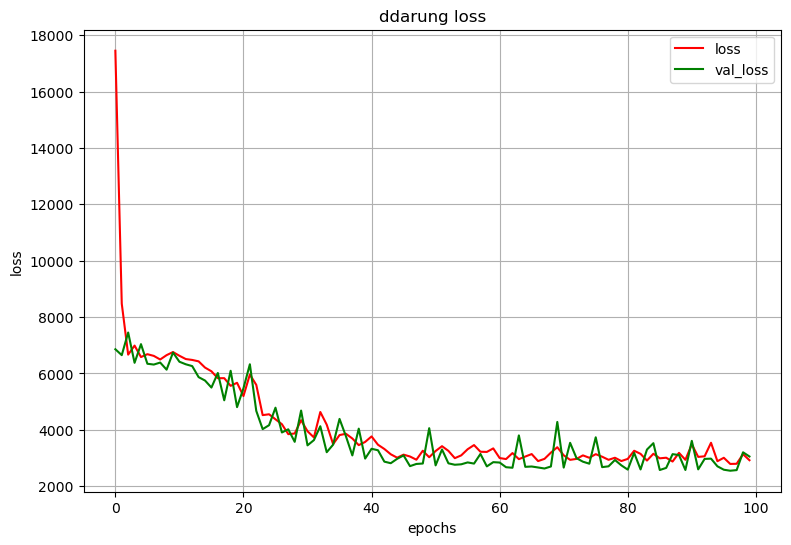

In [ ]:
# 시각화
import matplotlib.pyplot as plt

# 필롯의 사이즈
plt.figure(figsize =(9,6))
plt.plot(hist.history["loss"],c ="red",label="loss")
plt.plot(hist.history["val_loss"],c="green",label="val_loss")
plt.grid() # 격자 표시
plt.xlabel("epochs") # x 라벨 표시 
plt.ylabel("loss") # y 라벨 표시
plt.title("ddarung loss") # 그래프의 타이틀 표시
plt.legend(loc = "upper right") # 그래프의 범주 표시
plt.show() # 그래프를 보여줘